<a href="https://colab.research.google.com/github/Chwakillah/Airport-Sentiment-Analysis/blob/main/Analisis_Sentimen_Bandara_DM_KM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/Dataset/bandarabaru.csv')
df

,ulasan,rating,Check-in,Keamanan,Kenyamanan,Suasana,Fasilitas,Mobilitas,aspek,label final
0,Pelayanan buruk BUKAN customer 'service' tapi ...,1,Negatif,NaN,NaN,NaN,NaN,NaN,Check-in,Negatif
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,5,Positif,Positif,Positif,Positif,Positif,Positif,"Check-in, Keamanan, Kenyamanan, Suasana, Fasil...",Positif
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",5,NaN,NaN,NaN,NaN,Positif,NaN,Fasilitas,Positif
3,Bandara Sultan Mahmud Badaruddin II salah satu...,5,NaN,NaN,Positif,Positif,Positif,Positif,"Kenyamanan, Suasana, Fasilitas, Mobilitas",Positif
4,"Tidak ada budaya antri, mereka sedikit antrian...",1,NaN,NaN,Negatif,Negatif,NaN,NaN,"Kenyamanan, Suasana",Negatif
...,...,...,...,...,...,...,...,...,...,...
1013,"Pelayanan bagus, hanya saja di stasiun LRT toi...",4,Positif,NaN,NaN,NaN,Negatif,NaN,"Check-in, Fasilitas",Positif
1014,Yang datang ke palembang jika bingung tidak ad...,5,NaN,NaN,NaN,NaN,NaN,Positif,Mobilitas,Positif
1015,"Taman intai pesawat lewat, pinggir pagar banda...",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positif
1016,Parkir mobil sebaik nya ada atap shelter,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positif


In [ ]:
len(df.index)

1018

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ulasan       1018 non-null   object
 1   rating       1018 non-null   int64 
 2   Check-in     179 non-null    object
 3   Keamanan     51 non-null     object
 4   Kenyamanan   322 non-null    object
 5   Suasana      383 non-null    object
 6   Fasilitas    335 non-null    object
 7   Mobilitas    253 non-null    object
 8   aspek        821 non-null    object
 9   label final  1018 non-null   object
dtypes: int64(1), object(9)
memory usage: 79.7+ KB


# Cleaning Data

In [ ]:
#Melihat kolom content dan score
df= df[['ulasan','label final']]
df

,ulasan,label final
0,Pelayanan buruk BUKAN customer 'service' tapi ...,Negatif
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,Positif
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",Positif
3,Bandara Sultan Mahmud Badaruddin II salah satu...,Positif
4,"Tidak ada budaya antri, mereka sedikit antrian...",Negatif
...,...,...
1013,"Pelayanan bagus, hanya saja di stasiun LRT toi...",Positif
1014,Yang datang ke palembang jika bingung tidak ad...,Positif
1015,"Taman intai pesawat lewat, pinggir pagar banda...",Positif
1016,Parkir mobil sebaik nya ada atap shelter,Positif


In [ ]:
# Fungsi untuk menghapus emoji
def remove_emoji(tweet):
    if tweet is not None and isinstance(tweet, str):
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # geometric shapes extended
            u"\U0001F800-\U0001F8FF"  # supplemental arrows-C
            u"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
            u"\U0001FA00-\U0001FA6F"  # chess symbols
            u"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended-A
            u"\U0001F004-\U0001F0CF"  # additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)
    return tweet

# Fungsi untuk menghapus simbol
def remove_symbols(tweet):
    if tweet is not None and isinstance(tweet, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', tweet)  # Menghapus semua simbol
    return tweet

# Fungsi untuk menghapus angka
def remove_numbers(tweet):
    if tweet is not None and isinstance(tweet, str):
        return re.sub(r'\d', '', tweet)  # Menghapus semua angka
    return tweet

# Fungsi untuk menghapus username
def remove_username(text):
    return re.sub(r'@[^\s]+', '', text)

# Proses pembersihan data
df['ulasan_bersih'] = df['ulasan'].apply(remove_username)
df['ulasan_bersih'] = df['ulasan_bersih'].apply(remove_emoji)
df['ulasan_bersih'] = df['ulasan_bersih'].apply(remove_symbols)
df['ulasan_bersih'] = df['ulasan_bersih'].apply(remove_numbers)

df.head()


<ipython-input-7-3d3db1bfc683>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ulasan_bersih'] = df['ulasan'].apply(remove_username)
<ipython-input-7-3d3db1bfc683>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ulasan_bersih'] = df['ulasan_bersih'].apply(remove_emoji)
<ipython-input-7-3d3db1bfc683>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,ulasan,label final,ulasan_bersih
0,Pelayanan buruk BUKAN customer 'service' tapi ...,Negatif,Pelayanan buruk BUKAN customer service tapi cu...
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,Positif,Bandar Udara Domestik Sultan Mahmud Badaruddin...
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",Positif,kayanya bandara ini cuma terminal aja ngga ka...
3,Bandara Sultan Mahmud Badaruddin II salah satu...,Positif,Bandara Sultan Mahmud Badaruddin II salah satu...
4,"Tidak ada budaya antri, mereka sedikit antrian...",Negatif,Tidak ada budaya antri mereka sedikit antrian ...


In [ ]:
#Mengubah isi content menjadi huruf kecil
df['ulasan_lower']= df['ulasan_bersih'].str.lower()
df

<ipython-input-8-22d0cb9e9ae5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ulasan_lower']= df['ulasan_bersih'].str.lower()


,ulasan,label final,ulasan_bersih,ulasan_lower
0,Pelayanan buruk BUKAN customer 'service' tapi ...,Negatif,Pelayanan buruk BUKAN customer service tapi cu...,pelayanan buruk bukan customer service tapi cu...
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,Positif,Bandar Udara Domestik Sultan Mahmud Badaruddin...,bandar udara domestik sultan mahmud badaruddin...
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",Positif,kayanya bandara ini cuma terminal aja ngga ka...,kayanya bandara ini cuma terminal aja ngga ka...
3,Bandara Sultan Mahmud Badaruddin II salah satu...,Positif,Bandara Sultan Mahmud Badaruddin II salah satu...,bandara sultan mahmud badaruddin ii salah satu...
4,"Tidak ada budaya antri, mereka sedikit antrian...",Negatif,Tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antri mereka sedikit antrian ...
...,...,...,...,...
1013,"Pelayanan bagus, hanya saja di stasiun LRT toi...",Positif,Pelayanan bagus hanya saja di stasiun LRT toil...,pelayanan bagus hanya saja di stasiun lrt toil...
1014,Yang datang ke palembang jika bingung tidak ad...,Positif,Yang datang ke palembang jika bingung tidak ad...,yang datang ke palembang jika bingung tidak ad...
1015,"Taman intai pesawat lewat, pinggir pagar banda...",Positif,Taman intai pesawat lewat pinggir pagar bandar...,taman intai pesawat lewat pinggir pagar bandar...
1016,Parkir mobil sebaik nya ada atap shelter,Positif,Parkir mobil sebaik nya ada atap shelter,parkir mobil sebaik nya ada atap shelter


# Preprocessing

* normalisasi
* stopword
* tokenize
* stemming

## Normalisasi

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fornigulo/kamus-slag
!unzip kamus-slag.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/fornigulo/kamus-slag
License(s): RAIL
  0% 0.00/248k [00:00<?, ?B/s]
100% 248k/248k [00:00<00:00, 37.1MB/s]
Archive:  kamus-slag.zip
  inflating: kamuskatabaku.xlsx      


In [ ]:
import pandas as pd

# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() or char.isspace() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
                else:
                    replaced_words.append(word)
            else:
                replaced_words.append(word)

        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = ''
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash  # Pindahkan return ke luar if-else

In [ ]:
import pandas as pd

kamus_data = pd.read_excel('/content/drive/MyDrive/Dataset/kamuskatabaku.xlsx')
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

kamus_data.head()


,tidak_baku,kata_baku
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa


In [ ]:
# Terapkan fungsi penggantian kata tidak baku
data= df
data['hasil_normalisasi'], data['kata_Baku'], data['kata_Tidak_Baku'], data['kata_Tidak_Baku_Hash'] = zip(*data['ulasan_lower'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku)))

# data.head(100)
df= data
df = pd.DataFrame(data[['ulasan','label final','ulasan_bersih','ulasan_lower', "hasil_normalisasi"]])
df

<ipython-input-12-fc44ed63661f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hasil_normalisasi'], data['kata_Baku'], data['kata_Tidak_Baku'], data['kata_Tidak_Baku_Hash'] = zip(*data['ulasan_lower'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku)))
<ipython-input-12-fc44ed63661f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hasil_normalisasi'], data['kata_Baku'], data['kata_Tidak_Baku'], data['kata_Tidak_Baku_Hash'] = zip(*data['ulasan_lower'].apply(lambda x: replace_taboo_words

,ulasan,label final,ulasan_bersih,ulasan_lower,hasil_normalisasi
0,Pelayanan buruk BUKAN customer 'service' tapi ...,Negatif,Pelayanan buruk BUKAN customer service tapi cu...,pelayanan buruk bukan customer service tapi cu...,pelayanan buruk bukan pelanggan servis tapi pe...
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,Positif,Bandar Udara Domestik Sultan Mahmud Badaruddin...,bandar udara domestik sultan mahmud badaruddin...,bandara udara domestik sultan mahmud badaruddi...
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",Positif,kayanya bandara ini cuma terminal aja ngga ka...,kayanya bandara ini cuma terminal aja ngga ka...,sepertinya bandara ini cuma terminal saja tida...
3,Bandara Sultan Mahmud Badaruddin II salah satu...,Positif,Bandara Sultan Mahmud Badaruddin II salah satu...,bandara sultan mahmud badaruddin ii salah satu...,bandara sultan mahmud badaruddin ii salah satu...
4,"Tidak ada budaya antri, mereka sedikit antrian...",Negatif,Tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antre mereka sedikit antrian ...
...,...,...,...,...,...
1013,"Pelayanan bagus, hanya saja di stasiun LRT toi...",Positif,Pelayanan bagus hanya saja di stasiun LRT toil...,pelayanan bagus hanya saja di stasiun lrt toil...,pelayanan bagus hanya saja di stasiun lrt toil...
1014,Yang datang ke palembang jika bingung tidak ad...,Positif,Yang datang ke palembang jika bingung tidak ad...,yang datang ke palembang jika bingung tidak ad...,yang datang ke palembang jika bingung tidak ad...
1015,"Taman intai pesawat lewat, pinggir pagar banda...",Positif,Taman intai pesawat lewat pinggir pagar bandar...,taman intai pesawat lewat pinggir pagar bandar...,taman intai pesawat lewat pinggir pagar bandar...
1016,Parkir mobil sebaik nya ada atap shelter,Positif,Parkir mobil sebaik nya ada atap shelter,parkir mobil sebaik nya ada atap shelter,parkir mobil sebaik ya ada atap selter


## Tokenize

In [ ]:
# Tokenize teks dari kolom 'hasil_normalisasi'
df['tokenize'] = df['hasil_normalisasi'].fillna('').apply(lambda x: x.split())
df


,ulasan,label final,ulasan_bersih,ulasan_lower,hasil_normalisasi,tokenize
0,Pelayanan buruk BUKAN customer 'service' tapi ...,Negatif,Pelayanan buruk BUKAN customer service tapi cu...,pelayanan buruk bukan customer service tapi cu...,pelayanan buruk bukan pelanggan servis tapi pe...,"[pelayanan, buruk, bukan, pelanggan, servis, t..."
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,Positif,Bandar Udara Domestik Sultan Mahmud Badaruddin...,bandar udara domestik sultan mahmud badaruddin...,bandara udara domestik sultan mahmud badaruddi...,"[bandara, udara, domestik, sultan, mahmud, bad..."
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",Positif,kayanya bandara ini cuma terminal aja ngga ka...,kayanya bandara ini cuma terminal aja ngga ka...,sepertinya bandara ini cuma terminal saja tida...,"[sepertinya, bandara, ini, cuma, terminal, saj..."
3,Bandara Sultan Mahmud Badaruddin II salah satu...,Positif,Bandara Sultan Mahmud Badaruddin II salah satu...,bandara sultan mahmud badaruddin ii salah satu...,bandara sultan mahmud badaruddin ii salah satu...,"[bandara, sultan, mahmud, badaruddin, ii, sala..."
4,"Tidak ada budaya antri, mereka sedikit antrian...",Negatif,Tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antre mereka sedikit antrian ...,"[tidak, ada, budaya, antre, mereka, sedikit, a..."
...,...,...,...,...,...,...
1013,"Pelayanan bagus, hanya saja di stasiun LRT toi...",Positif,Pelayanan bagus hanya saja di stasiun LRT toil...,pelayanan bagus hanya saja di stasiun lrt toil...,pelayanan bagus hanya saja di stasiun lrt toil...,"[pelayanan, bagus, hanya, saja, di, stasiun, l..."
1014,Yang datang ke palembang jika bingung tidak ad...,Positif,Yang datang ke palembang jika bingung tidak ad...,yang datang ke palembang jika bingung tidak ad...,yang datang ke palembang jika bingung tidak ad...,"[yang, datang, ke, palembang, jika, bingung, t..."
1015,"Taman intai pesawat lewat, pinggir pagar banda...",Positif,Taman intai pesawat lewat pinggir pagar bandar...,taman intai pesawat lewat pinggir pagar bandar...,taman intai pesawat lewat pinggir pagar bandar...,"[taman, intai, pesawat, lewat, pinggir, pagar,..."
1016,Parkir mobil sebaik nya ada atap shelter,Positif,Parkir mobil sebaik nya ada atap shelter,parkir mobil sebaik nya ada atap shelter,parkir mobil sebaik ya ada atap selter,"[parkir, mobil, sebaik, ya, ada, atap, selter]"


## Stopword

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(text):
  return [word for word in text if word not in stopwords]

df['stopword'] = df['tokenize'].apply(lambda x: remove_stopwords(x))
df

,ulasan,label final,ulasan_bersih,ulasan_lower,hasil_normalisasi,tokenize,stopword
0,Pelayanan buruk BUKAN customer 'service' tapi ...,Negatif,Pelayanan buruk BUKAN customer service tapi cu...,pelayanan buruk bukan customer service tapi cu...,pelayanan buruk bukan pelanggan servis tapi pe...,"[pelayanan, buruk, bukan, pelanggan, servis, t...","[pelayanan, buruk, pelanggan, servis, pelangga..."
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,Positif,Bandar Udara Domestik Sultan Mahmud Badaruddin...,bandar udara domestik sultan mahmud badaruddin...,bandara udara domestik sultan mahmud badaruddi...,"[bandara, udara, domestik, sultan, mahmud, bad...","[bandara, udara, domestik, sultan, mahmud, bad..."
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",Positif,kayanya bandara ini cuma terminal aja ngga ka...,kayanya bandara ini cuma terminal aja ngga ka...,sepertinya bandara ini cuma terminal saja tida...,"[sepertinya, bandara, ini, cuma, terminal, saj...","[bandara, terminal, soekarno, hatta, terminal,..."
3,Bandara Sultan Mahmud Badaruddin II salah satu...,Positif,Bandara Sultan Mahmud Badaruddin II salah satu...,bandara sultan mahmud badaruddin ii salah satu...,bandara sultan mahmud badaruddin ii salah satu...,"[bandara, sultan, mahmud, badaruddin, ii, sala...","[bandara, sultan, mahmud, badaruddin, ii, sala..."
4,"Tidak ada budaya antri, mereka sedikit antrian...",Negatif,Tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antre mereka sedikit antrian ...,"[tidak, ada, budaya, antre, mereka, sedikit, a...","[budaya, antre, antrian, marah, petugas, diam,..."
...,...,...,...,...,...,...,...
1013,"Pelayanan bagus, hanya saja di stasiun LRT toi...",Positif,Pelayanan bagus hanya saja di stasiun LRT toil...,pelayanan bagus hanya saja di stasiun lrt toil...,pelayanan bagus hanya saja di stasiun lrt toil...,"[pelayanan, bagus, hanya, saja, di, stasiun, l...","[pelayanan, bagus, stasiun, lrt, toiletnya, tu..."
1014,Yang datang ke palembang jika bingung tidak ad...,Positif,Yang datang ke palembang jika bingung tidak ad...,yang datang ke palembang jika bingung tidak ad...,yang datang ke palembang jika bingung tidak ad...,"[yang, datang, ke, palembang, jika, bingung, t...","[palembang, bingung, jemput, coba, kereta, kota]"
1015,"Taman intai pesawat lewat, pinggir pagar banda...",Positif,Taman intai pesawat lewat pinggir pagar bandar...,taman intai pesawat lewat pinggir pagar bandar...,taman intai pesawat lewat pinggir pagar bandar...,"[taman, intai, pesawat, lewat, pinggir, pagar,...","[taman, intai, pesawat, pinggir, pagar, bandar..."
1016,Parkir mobil sebaik nya ada atap shelter,Positif,Parkir mobil sebaik nya ada atap shelter,parkir mobil sebaik nya ada atap shelter,parkir mobil sebaik ya ada atap selter,"[parkir, mobil, sebaik, ya, ada, atap, selter]","[parkir, mobil, ya, atap, selter]"


## Stemming

In [ ]:
!pip  install Sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
  return [stemmer.stem(word) for word in text]

df['stemming'] = df['stopword'].apply(lambda x: ' '.join(stem_text(x)))
df.head(40)

,ulasan,label final,ulasan_bersih,ulasan_lower,hasil_normalisasi,tokenize,stopword,stemming
0,Pelayanan buruk BUKAN customer 'service' tapi ...,Negatif,Pelayanan buruk BUKAN customer service tapi cu...,pelayanan buruk bukan customer service tapi cu...,pelayanan buruk bukan pelanggan servis tapi pe...,"[pelayanan, buruk, bukan, pelanggan, servis, t...","[pelayanan, buruk, pelanggan, servis, pelangga...",layan buruk langgan servis langgan trauma tema...
1,Bandar Udara Domestik Sultan Mahmud Badaruddin...,Positif,Bandar Udara Domestik Sultan Mahmud Badaruddin...,bandar udara domestik sultan mahmud badaruddin...,bandara udara domestik sultan mahmud badaruddi...,"[bandara, udara, domestik, sultan, mahmud, bad...","[bandara, udara, domestik, sultan, mahmud, bad...",bandara udara domestik sultan mahmud badaruddi...
2,"kayanya bandara ini cuma 1 terminal aja, ngga ...",Positif,kayanya bandara ini cuma terminal aja ngga ka...,kayanya bandara ini cuma terminal aja ngga ka...,sepertinya bandara ini cuma terminal saja tida...,"[sepertinya, bandara, ini, cuma, terminal, saj...","[bandara, terminal, soekarno, hatta, terminal,...",bandara terminal soekarno hatta terminal ruang...
3,Bandara Sultan Mahmud Badaruddin II salah satu...,Positif,Bandara Sultan Mahmud Badaruddin II salah satu...,bandara sultan mahmud badaruddin ii salah satu...,bandara sultan mahmud badaruddin ii salah satu...,"[bandara, sultan, mahmud, badaruddin, ii, sala...","[bandara, sultan, mahmud, badaruddin, ii, sala...",bandara sultan mahmud badaruddin ii salah band...
4,"Tidak ada budaya antri, mereka sedikit antrian...",Negatif,Tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antri mereka sedikit antrian ...,tidak ada budaya antre mereka sedikit antrian ...,"[tidak, ada, budaya, antre, mereka, sedikit, a...","[budaya, antre, antrian, marah, petugas, diam,...",budaya antre antri marah tugas diam tata sopan...
5,Semakin ga terawat ini bandara. International ...,Negatif,Semakin ga terawat ini bandara International a...,semakin ga terawat ini bandara international a...,semakin tidak terawat ini bandara internasiona...,"[semakin, tidak, terawat, ini, bandara, intern...","[terawat, bandara, internasional, bandara, mal...",awat bandara internasional bandara malam gelap...
6,Bandaranya kecil & ga terlalu ramai mgkn krn g...,Negatif,Bandaranya kecil ga terlalu ramai mgkn krn ga...,bandaranya kecil ga terlalu ramai mgkn krn ga...,bandaranya kecil tidak terlalu ramai mungkin k...,"[bandaranya, kecil, tidak, terlalu, ramai, mun...","[bandaranya, ramai, jadwal, penerbangannya, ca...",bandara ramai jadwal terbang cari isi daya sus...
7,Bandara Internasional Sultan Mahmud Badaruddin...,Positif,Bandara Internasional Sultan Mahmud Badaruddin...,bandara internasional sultan mahmud badaruddin...,bandara internasional sultan mahmud badaruddin...,"[bandara, internasional, sultan, mahmud, badar...","[bandara, internasional, sultan, mahmud, badar...",bandara internasional sultan mahmud badaruddin...
8,Fasilitas Bandara ini masih banyak yang perlu ...,Negatif,Fasilitas Bandara ini masih banyak yang perlu ...,fasilitas bandara ini masih banyak yang perlu ...,fasilitas bandara ini masih banyak yang perlu ...,"[fasilitas, bandara, ini, masih, banyak, yang,...","[fasilitas, bandara, dibenahi, air, toilet, la...",fasilitas bandara benah air toilet lancar drop...
9,Bandar udara internasional Sultan Mahmud Badar...,Positif,Bandar udara internasional Sultan Mahmud Badar...,bandar udara internasional sultan mahmud badar...,bandara udara internasional sultan mahmud bada...,"[bandara, udara, internasional, sultan, mahmud...","[bandara, udara, internasional, sultan, mahmud...",bandara udara internasional sultan mahmud bada...


# SMOTE

In [ ]:
#Melihat jumlah positif dan negatif
counts = df['label final'].value_counts()
counts

,count
label final,
Positif,767
Negatif,251


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
import collections

# Ubah teks menjadi fitur numerik dengan CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['stemming'])

# Cek distribusi sebelum SMOTE
print("Distribusi sebelum SMOTE:", collections.Counter(df['label final']))

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, df['label final'])

# Cek distribusi setelah SMOTE
print("Distribusi setelah SMOTE:", collections.Counter(y_resampled))

Distribusi sebelum SMOTE: Counter({'Positif': 767, 'Negatif': 251})
Distribusi setelah SMOTE: Counter({'Negatif': 767, 'Positif': 767})


# Spilting Data

In [ ]:
#Skenario membagi dataset menjadi 90:10
# Split data setelah SMOTE (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42, stratify=y_resampled)


In [ ]:
#Melihat jumlah data yang dibagi
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (1380, 1868)
X_test_shape :  (154, 1868)
y_train_shape :  (1380,)
y_test_shape :  (154,)


In [ ]:
# Inisialisasi TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Transformasi data hasil CountVectorizer ke TF-IDF
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

# Menampilkan nilai IDF
print('\nIDF values:')
for word, idf_value in zip(vectorizer.get_feature_names_out(), tfidf_transformer.idf_):
    print(word, ':', idf_value)

# Menampilkan indeks kata dalam vocabulary
print('\nWord indexes:')
print(vectorizer.vocabulary_)

# Menampilkan nilai TF-IDF
print('\nTF-IDF value:')
print(X_train_tfidf)

# Menampilkan nilai TF-IDF dalam bentuk matriks
print('\nTF-IDF values in matrix form:')
print(X_train_tfidf.toarray())



IDF values:
abai : 7.537415972849347
abu : 6.844268792289402
acak : 6.844268792289402
acara : 5.665613795947755
aceh : 7.537415972849347
acu : 6.844268792289402
acung : 7.537415972849347
ada : 5.745656503621292
adab : 7.537415972849347
adad : 7.537415972849347
adakan : 7.537415972849347
adat : 6.0333385760730724
adek : 7.537415972849347
adib : 7.537415972849347
adik : 6.621125240975192
aduh : 5.665613795947755
adul : 6.844268792289402
afdal : 7.537415972849347
agam : 6.621125240975192
agen : 7.537415972849347
agenda : 8.230563153409292
agung : 7.1319508647411824
agustus : 7.537415972849347
ahmad : 7.537415972849347
aih : 7.537415972849347
ain : 7.537415972849347
air : 4.6752150919198785
airasia : 7.1319508647411824
airbus : 6.844268792289402
airport : 6.438803684181237
aja : 7.537415972849347
ajak : 6.621125240975192
ajar : 7.537415972849347
aji : 7.537415972849347
aju : 7.1319508647411824
akal : 8.230563153409292
akan : 7.537415972849347
akbar : 8.230563153409292
akhir : 7.5374159728

# Tranining Data

## Naive Bayes

In [ ]:
#Membuat model naive bayes
model_naive = MultinomialNB()
model_naive.fit(X_train_tfidf, y_train)


MultinomialNB()

In [ ]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
y_pred_naive = model_naive.predict(X_test_tfidf)

In [ ]:
#Akurasi Naive Bayes
accuracy = accuracy_score(y_test, y_pred_naive)
print("Accuracy dengan Naive-bayes: ",accuracy)

Accuracy dengan Naive-bayes:  0.8376623376623377


In [ ]:
#Evaluasi Model Naive Bayes
clf_naive = MultinomialNB()
clf_naive.fit(X_train_tfidf, y_train)
predicted_naive = clf_naive.predict(X_test_tfidf)

print("MultinomialNB Accuracy:", accuracy_score(y_test,predicted_naive))
print("MultinomialNB Precision:", precision_score(y_test,predicted_naive, average="binary", pos_label="Negatif"))
print("MultinomialNB Recall:", recall_score(y_test,predicted_naive, average="binary", pos_label="Negatif"))
print("MultinomialNB f1_score:", f1_score(y_test,predicted_naive, average="binary", pos_label="Negatif"))

print(f'confusion_matrix:\n {confusion_matrix(y_test, predicted_naive)}')
print('====================================================\n')
print(classification_report(y_test, predicted_naive, zero_division=0))


MultinomialNB Accuracy: 0.8376623376623377
MultinomialNB Precision: 0.8714285714285714
MultinomialNB Recall: 0.7922077922077922
MultinomialNB f1_score: 0.8299319727891157
confusion_matrix:
 [[61 16]
 [ 9 68]]

              precision    recall  f1-score   support

     Negatif       0.87      0.79      0.83        77
     Positif       0.81      0.88      0.84        77

    accuracy                           0.84       154
   macro avg       0.84      0.84      0.84       154
weighted avg       0.84      0.84      0.84       154



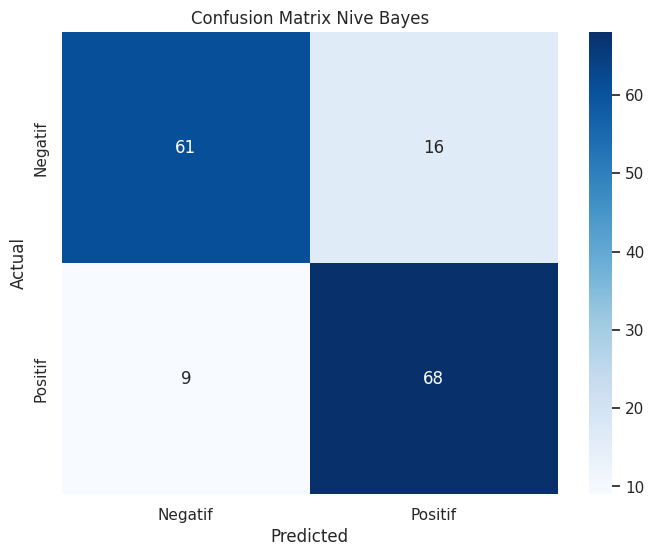

In [ ]:
conf_matrix = confusion_matrix(y_test, predicted_naive)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Nive Bayes")
plt.show()


## SVM

SVM Accuracy: 0.8571428571428571
SVM Precision: 0.8395061728395061
SVM Recall: 0.8831168831168831
SVM f1_score: 0.8607594936708861


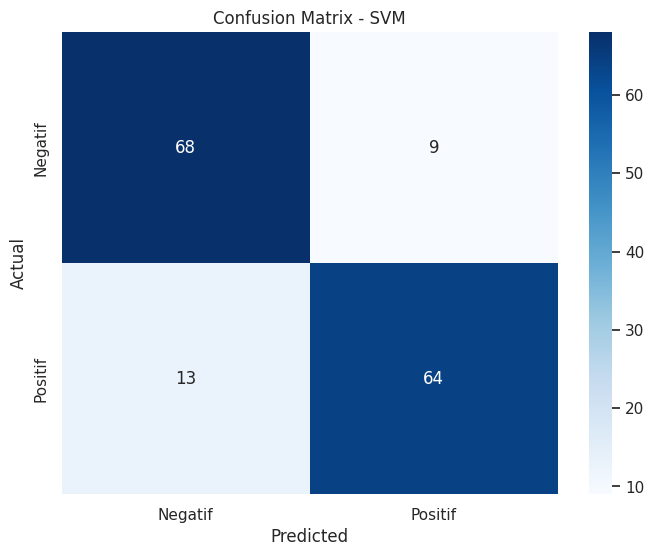

In [ ]:
# Membuat model SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_tfidf, y_train)

# Prediksi dengan SVM
y_pred_svm = model_svm.predict(X_test_tfidf)

# Evaluasi Model SVM
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Precision:", precision_score(y_test, y_pred_svm, average="binary", pos_label="Negatif"))
print("SVM Recall:", recall_score(y_test, y_pred_svm, average="binary", pos_label="Negatif"))
print("SVM f1_score:", f1_score(y_test, y_pred_svm, average="binary", pos_label="Negatif"))

# Confusion Matrix SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()


## Random Forest

Random Forest Accuracy: 0.8506493506493507
Random Forest Precision: 0.8461538461538461
Random Forest Recall: 0.8571428571428571
Random Forest f1_score: 0.8516129032258064


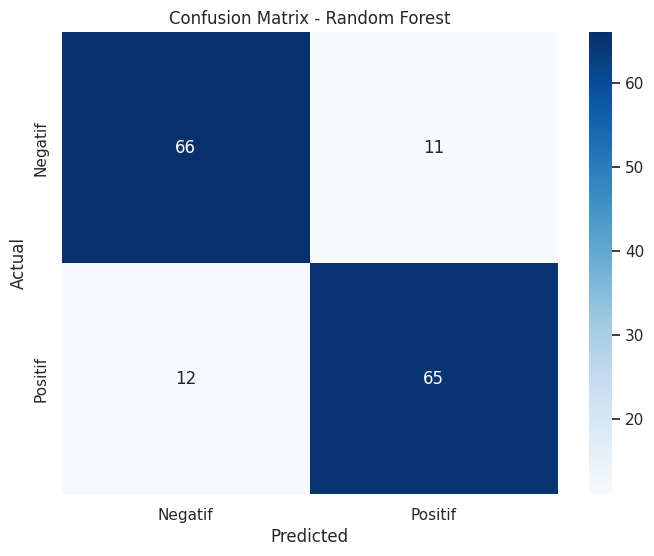

In [ ]:
# Membuat model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)

# Prediksi dengan Random Forest
y_pred_rf = model_rf.predict(X_test_tfidf)

# Evaluasi Model Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Precision:", precision_score(y_test, y_pred_rf, average="binary", pos_label="Negatif"))
print("Random Forest Recall:", recall_score(y_test, y_pred_rf, average="binary", pos_label="Negatif"))
print("Random Forest f1_score:", f1_score(y_test, y_pred_rf, average="binary", pos_label="Negatif"))

# Confusion Matrix Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


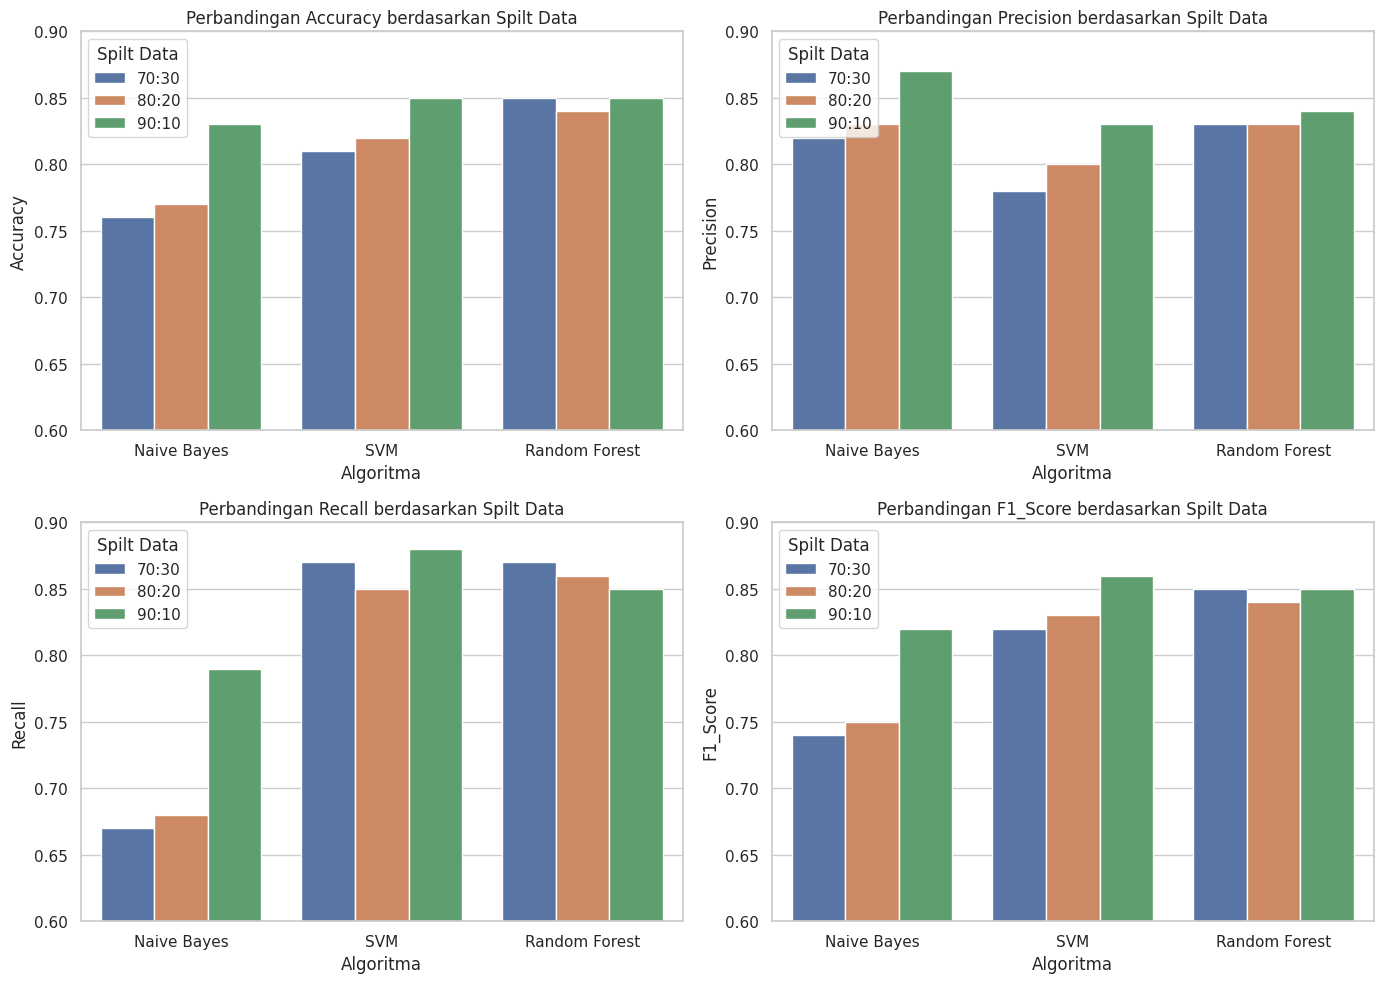

In [ ]:
# Data hasil analisis sentimen yang telah diperbarui
data = {
    "Spilt Data": ["70:30", "70:30", "70:30", "80:20", "80:20", "80:20", "90:10", "90:10", "90:10"],
    "Algoritma": ["Naive Bayes", "SVM", "Random Forest", "Naive Bayes", "SVM", "Random Forest", "Naive Bayes", "SVM", "Random Forest"],
    "Accuracy": [0.76, 0.81, 0.85, 0.77, 0.82, 0.84, 0.83, 0.85, 0.85],
    "Precision": [0.82, 0.78, 0.83, 0.83, 0.80, 0.83, 0.87, 0.83, 0.84],
    "Recall": [0.67, 0.87, 0.87, 0.68, 0.85, 0.86, 0.79, 0.88, 0.85],
    "F1_Score": [0.74, 0.82, 0.85, 0.75, 0.83, 0.84, 0.82, 0.86, 0.85]
}

# Konversi ke DataFrame
df = pd.DataFrame(data)

# Set style seaborn
sns.set(style="whitegrid")

# Membuat visualisasi dengan subplots
metrics = ["Accuracy", "Precision", "Recall", "F1_Score"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, metric in zip(axes.flatten(), metrics):
    sns.barplot(x="Algoritma", y=metric, hue="Spilt Data", data=df, ax=ax)
    ax.set_title(f"Perbandingan {metric} berdasarkan Spilt Data")
    ax.set_ylim(0.6, 0.9)  # Set batas nilai
    ax.legend(title="Spilt Data")

plt.tight_layout()
plt.show()

